<a href="https://colab.research.google.com/github/Riky2014/Tesi/blob/main/1d_hemo_solver_branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install fenics

In [2]:
from fenics import *

import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the logging level to suppress FFC messages
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFL_LEGACY').setLevel(logging.WARNING)

# Data, Mesh and Function spaces

In [3]:
# Data
x_inlet = 0.
x_branch = 1.0
x_outlet_1 = 2.0
x_outlet_2 = 3.0
T = 1

alpha = 1
k_r = 2.419
rho = 1.050

# Discretization parameter
dt = 2e-5
num_steps = T / dt

h_1 = 1 / 32
h_2 = 1 / 32
h_3 = 1 / 32
N_1 = int((x_branch - x_inlet) / h_1)
N_2 = int((x_outlet_1 - x_branch) / h_2)
N_3 = int((x_outlet_2 - x_branch) / h_3)

#  Create a mesh on the interval [0, 1], [1, 2] and [1, 3].
mesh_1 = IntervalMesh(N_1, x_inlet, x_branch)
mesh_2 = IntervalMesh(N_2, x_branch, x_outlet_1)
mesh_3 = IntervalMesh(N_3, x_branch, x_outlet_2)

# Define the function space
P1_1 = FiniteElement('P', mesh_1.ufl_cell(), 1)
P1_2 = FiniteElement('P', mesh_2.ufl_cell(), 1)
P1_3 = FiniteElement('P', mesh_3.ufl_cell(), 1)
element_1 = MixedElement([P1_1, P1_1])
element_2 = MixedElement([P1_2, P1_2])
element_3 = MixedElement([P1_3, P1_3])
V_1 = FunctionSpace(mesh_1, element_1)
V_2 = FunctionSpace(mesh_2, element_2)
V_3 = FunctionSpace(mesh_3, element_3)

# Derivative function space
D1_1 = FiniteElement('DG', mesh_1.ufl_cell(), 0)
D1_2 = FiniteElement('DG', mesh_2.ufl_cell(), 0)
D1_3 = FiniteElement('DG', mesh_3.ufl_cell(), 0)
element_der_1 = MixedElement([D1_1, D1_1])
element_der_2 = MixedElement([D1_2, D1_2])
element_der_3 = MixedElement([D1_3, D1_3])
V_der_1 = FunctionSpace(mesh_1, element_der_1)
V_der_2 = FunctionSpace(mesh_2, element_der_2)
V_der_3 = FunctionSpace(mesh_3, element_der_3)

In [4]:
h_1 / dt

1562.4999999999998

# Functions

In [5]:
def H(A, q, A0, beta):
  return as_tensor([[0, 1], [beta / (2 * rho * A0) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def F(A, q, A0, beta):
  return as_vector([q, beta / (3 * rho * A0) * A ** 1.5 - beta / (3 * rho) * A0 ** 0.5 + q ** 2 / A])

def B(A, q):
  return as_vector([0, k_r * q / A])

def S(A, q):
  return as_vector([0, k_r * q / A])

def dS_dU(A, q):
  return as_tensor([[0, 0], [- k_r * q / A ** 2, k_r / A]])

In [6]:
def U(A, q):
  return np.array([A, q])

def H_vec(A, q, A0, beta):
  return np.array([[0, 1], [beta / (2 * rho * A0) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def B_vec(A, q):
  return np.array([0, k_r * q / A])

def S_vec(A, q):
  return np.array([0, k_r * q / A])

def c_alpha(A, q, A0, beta, alpha = 1):
  return (beta / (2 * rho * A0) * A ** 0.5 + (q / A) ** 2 * alpha * (alpha - 1)) ** 0.5

def l1(A, q, A0, beta, alpha = 1):
  return np.array([c_alpha(A, q, A0, beta, alpha) - alpha * q / A, 1.])

def l2(A, q, A0, beta, alpha = 1):
  return np.array([- c_alpha(A, q, A0, beta, alpha) - alpha * q / A, 1.])

def CC(A, q, A0, beta, u_der, V_der, x):
  du_dz = project(u_der, V_der)(x)
  return U(A, q) - dt * H_vec(A, q, A0, beta) @ du_dz - dt * B_vec(A, q)

In [7]:
def inlet_bc(A, q, A0, beta, u_der, V_der, x):
  q_inlet = (np.dot(l2(A(x), q(x), A0, beta), CC(A(x), q(x), A0, beta, u_der, V_der, x)) - l2(A(x), q(x), A0, beta)[0] * U(A(x), q(x))[0] ) / l2(A(x), q(x), A0, beta)[1]

  return q_inlet

def outlet_bc(A, q, A0, beta, u_der, V_der, x):
  matrix = np.array([[1, -1], [c_alpha(A(x), q(x), A0, beta, alpha) + alpha * q(x) / A(x), c_alpha(A(x), q(x), A0, beta, alpha) - alpha * q(x) / A(x)]])
  array = np.array([np.dot(l1(A(x), q(x), A0, beta), CC(A(x), q(x), A0, beta, u_der, V_der, x)), np.dot(l2(A(x), q(x), A0, beta), U(A(x), q(x)) - dt * S_vec(A(x), q(x)))])

  A_out, q_out = matrix @ array / (2 * c_alpha(A(x), q(x), A0, beta, alpha))

  return A_out, q_out

# Definition of the variational problem

In [8]:
def local_branch_solution(bc, V, A_old, q_old, A0, beta):
  # Define trial functions and test functions
  A, q = TrialFunctions(V)
  v, z = TestFunctions(V)
  uh = Function(V)

  a, l = LinearProblem(A, q, v, z, A_old, q_old, A0, beta)
  solve(a == l, uh, bc)

  return uh

In [9]:
# Define the variational problem
def LinearProblem(A, q, v, z, A_old, q_old, A0, beta):
  a = inner(A, v) * dx + inner(q, z) * dx

  l = (
        A_old * v * dx
      + q_old * z * dx
      + dt * ((F(A_old, q_old, A0, beta) - dt / 2 * dot(H(A_old, q_old, A0, beta), S(A_old, q_old))))[0] * v.dx(0) * dx
      + dt * ((F(A_old, q_old, A0, beta) - dt / 2 * dot(H(A_old, q_old, A0, beta), S(A_old, q_old))))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, beta).dx(0)))[0] * v * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, beta).dx(0)))[1] * z * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, beta), F(A_old, q_old, A0, beta).dx(0)))[0] * v.dx(0) * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, beta), F(A_old, q_old, A0, beta).dx(0)))[1] * z.dx(0) * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[0] * v * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[1] * z * dx
  )

  return a, l

# Branching

In [10]:
def C_A_in(A, q, A0, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 - 2 * gamma * np.sign(q))

def C_q_in(A, q, A0, gamma):
  return (q / A ** 2) * (1 - 2 * gamma * np.sign(q))

def b_in(A, q, A0, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 - 2 * gamma * np.sign(q))

def C_A_out(A, q, A0, alpha, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def C_q_out(A, q, A0, alpha, gamma):
  return (q / A ** 2) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def b_out(A, q, A0, alpha, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

In [11]:
def compute_branch_value(Ah_1, Ah_2, Ah_3, qh_1, qh_2, qh_3, uh_old_1, uh_old_2, uh_old_3, x_branch, toll):

  A_branch_old_1 = Ah_1(x_branch)
  A_branch_old_2 = Ah_2(x_branch)
  A_branch_old_3 = Ah_3(x_branch)

  q_branch_old_1 = qh_1(x_branch)
  q_branch_old_2 = qh_2(x_branch)
  q_branch_old_3 = qh_3(x_branch)

  A_branch_0_1 = A_branch_old_1
  A_branch_0_2 = A_branch_old_2
  A_branch_0_3 = A_branch_old_3

  q_branch_0_1 = q_branch_old_1
  q_branch_0_2 = q_branch_old_2
  q_branch_0_3 = q_branch_old_3

  err = float('inf')
  iter = 0

  while (err > toll) & (iter < 100):

    iter += 1

    lhs = np.zeros((6, 6))
    rhs = np.zeros(6)

    lhs[0, 3] =  1
    lhs[0, 4] = -1
    lhs[0, 5] = -1

    lhs[1, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    lhs[1, 1] = - C_A_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, beta_2, gamma_2)
    lhs[1, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, A0_1, gamma_1)
    lhs[1, 4] = - C_q_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, gamma_2)

    lhs[2, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    lhs[2, 2] = - C_A_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, beta_3, gamma_3)
    lhs[2, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, A0_1, gamma_1)
    lhs[2, 5] = - C_q_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, gamma_3)

    lhs[3, 0] = l1(A_branch_0_1, q_branch_0_1, A0_1, beta_1)[0]
    lhs[3, 3] = l1(A_branch_0_1, q_branch_0_1, A0_1, beta_1)[1]

    lhs[4, 1] = l2(A_branch_0_2, q_branch_0_2, A0_2, beta_2)[0]
    lhs[4, 4] = l2(A_branch_0_2, q_branch_0_2, A0_2, beta_2)[1]

    lhs[5, 2] = l2(A_branch_0_3, q_branch_0_3, A0_3, beta_3)[0]
    lhs[5, 5] = l2(A_branch_0_3, q_branch_0_3, A0_3, beta_3)[1]

    rhs[1] = b_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, beta_2, gamma_2) - b_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    rhs[2] = b_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, beta_3, gamma_3) - b_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    rhs[3] = np.dot(l1(A_branch_0_1, q_branch_0_1, A0_1, beta_1), CC(A_branch_0_1, q_branch_0_1, A0_1, beta_1, uh_old_1.dx(0), V_der_1, x_branch))
    rhs[4] = np.dot(l2(A_branch_0_2, q_branch_0_2, A0_2, beta_2), CC(A_branch_0_2, q_branch_0_2, A0_2, beta_2, uh_old_2.dx(0), V_der_2, x_branch))
    rhs[5] = np.dot(l2(A_branch_0_3, q_branch_0_3, A0_3, beta_3), CC(A_branch_0_3, q_branch_0_3, A0_3, beta_3, uh_old_3.dx(0), V_der_3, x_branch))

    A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3 = np.linalg.solve(lhs, rhs)

    if (q_branch_0_1 == 0) or (q_branch_0_2 == 0) or (q_branch_0_3 == 0):
      err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
          + abs(q_branch_1 - q_branch_old_1) + abs(q_branch_2 - q_branch_old_2) + abs(q_branch_3 - q_branch_old_3)
    else:
      err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
          + abs(q_branch_1 - q_branch_old_1) / q_branch_0_1 + abs(q_branch_2 - q_branch_old_2) / q_branch_0_2 + abs(q_branch_3 - q_branch_old_3) / q_branch_0_3

    # err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
    #     + abs(q_branch_1 - q_branch_old_1) + abs(q_branch_2 - q_branch_old_2) + abs(q_branch_3 - q_branch_old_3)

    A_branch_old_1 = A_branch_1
    A_branch_old_2 = A_branch_2
    A_branch_old_3 = A_branch_3

    q_branch_old_1 = q_branch_1
    q_branch_old_2 = q_branch_2
    q_branch_old_3 = q_branch_3

  res_2, res_3 = check_non_linear_system(A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3)
  #print(res_2, res_3)

  return A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter

In [12]:
def g_1(A, q, gamma):
  return gamma * (q / A) ** 2

def g_i(A, q, gamma, alpha):
  return gamma * (q / A) ** 2 * sqrt(2 * (1 - cos(alpha)))

def check_non_linear_system(A1, A2, A3, q1, q2, q3):
  res_2 = beta_1 / (rho * A0_1) * (sqrt(A1) - sqrt(A0_1)) + 0.5 * (q1 / A1) ** 2 - np.sign(q1 / A1) * g_1(A1, q1, gamma_1) \
       - beta_2 / (rho * A0_2) * (sqrt(A2) - sqrt(A0_2)) - 0.5 * (q2 / A2) ** 2 - np.sign(q2 / A2) * g_i(A2, q2, gamma_2, alpha_2)
  res_3 = beta_1 / (rho * A0_1) * (sqrt(A1) - sqrt(A0_1)) + 0.5 * (q1 / A1) ** 2 - np.sign(q1 / A1) * g_1(A1, q1, gamma_1) \
       - beta_3 / (rho * A0_3) * (sqrt(A3) - sqrt(A0_3)) - 0.5 * (q3 / A3) ** 2 - np.sign(q3 / A3) * g_i(A3, q3, gamma_3, alpha_3)

  return res_2, res_3

# Initial guess

In [23]:
# Define initial guess
A0_1 = 0.126  # Celiac II
A0_2 = 0.126
A0_3 = 0.126

q0_1 = 0
q0_2 = 0
q0_3 = 0

uh_old_1 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_1, q0 = q0_1), V_1)
uh_old_2 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_2, q0 = q0_2), V_2)
uh_old_3 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_3, q0 = q0_3), V_3)

Ah_old_1, qh_old_1 = uh_old_1.split()
Ah_old_2, qh_old_2 = uh_old_2.split()
Ah_old_3, qh_old_3 = uh_old_3.split()

# Boundary conditon

In [24]:
beta_1 = 0.060606e7
beta_2 = 0.060606e7
beta_3 = 0.060606e7

gamma_1 = 0 # see https://www.researchgate.net/publication/37445437_One-dimensional_models_for_blood_flow_in_arteries pag 12 for reference values
gamma_2 = 2
gamma_3 = 2

alpha_2 = pi / 3
alpha_3 = pi / 4

In [25]:
# Boundary condition
inlet = 'near(x[0], 0)'
branch = 'near(x[0], 1)'
outlet_1 = 'near(x[0], 2)'
outlet_2 = 'near(x[0], 3)'

A_inlet = Ah_old_1(x_inlet)
q_inlet = inlet_bc(Ah_old_1, qh_old_1, A0_1, beta_1, uh_old_1.dx(0), V_der_1, x_inlet)

A_outlet_1, q_outlet_1 = outlet_bc(Ah_old_2, qh_old_2, A0_2, beta_2, uh_old_2.dx(0), V_der_2, x_outlet_1)
A_outlet_2, q_outlet_2 = outlet_bc(Ah_old_3, qh_old_3, A0_3, beta_3, uh_old_3.dx(0), V_der_3, x_outlet_2)

A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter = compute_branch_value(Ah_old_1, Ah_old_2, Ah_old_3, qh_old_1, qh_old_2, qh_old_3, uh_old_1, uh_old_2, uh_old_3,x_branch, 1e-4)

print(f'A inlet = {A_inlet}, q inlet = {q_inlet}, A_1 branch = {A_branch_1}, q_1 branch = {q_branch_1}')
print(f'A_2 branch = {A_branch_2}, q_2 branch = {q_branch_2}, A outlet_1 = {A_outlet_1}, q outlet_1 = {q_outlet_1}')
print(f'A_3 branch = {A_branch_3}, q_3 branch = {q_branch_3}, A outlet_2 = {A_outlet_2}, q outlet_2 = {q_outlet_2}')

A inlet = 0.126, q inlet = 0.0, A_1 branch = 0.12599999999999997, q_1 branch = -4.736951571734001e-15
A_2 branch = 0.12599999999999997, q_2 branch = 4.736951571734001e-15, A outlet_1 = 0.126, q outlet_1 = -2.316961079421611e-15
A_3 branch = 0.12599999999999997, q_3 branch = -9.473903143468002e-15, A outlet_2 = 0.126, q outlet_2 = -2.316961079421611e-15


In [26]:
def update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3):

  bc_A_inlet    = DirichletBC(V_1.sub(0), A_inlet, inlet)
  bc_q_inlet    = DirichletBC(V_1.sub(1), q_inlet, inlet)
  bc_A_branch_1 = DirichletBC(V_1.sub(0), A_branch_1, branch)
  bc_q_branch_1 = DirichletBC(V_1.sub(1), q_branch_1, branch)

  bc_A_branch_2 = DirichletBC(V_2.sub(0), A_branch_2, branch)
  bc_q_branch_2 = DirichletBC(V_2.sub(1), q_branch_2, branch)
  bc_A_outlet_1 = DirichletBC(V_2.sub(0), A_outlet_1, outlet_1)
  bc_q_outlet_1 = DirichletBC(V_2.sub(1), q_outlet_1, outlet_1)

  bc_A_branch_3 = DirichletBC(V_3.sub(0), A_branch_3, branch)
  bc_q_branch_3 = DirichletBC(V_3.sub(1), q_branch_3, branch)
  bc_A_outlet_2 = DirichletBC(V_3.sub(0), A_outlet_2, outlet_2)
  bc_q_outlet_2 = DirichletBC(V_3.sub(1), q_outlet_2, outlet_2)

  bc_1 = [bc_A_inlet, bc_q_inlet, bc_A_branch_1, bc_q_branch_1]
  bc_2 = [bc_A_outlet_1, bc_q_outlet_1, bc_A_branch_2, bc_q_branch_2]
  bc_3 = [bc_A_outlet_2, bc_q_outlet_2, bc_A_branch_3, bc_q_branch_3]

  return bc_1, bc_2, bc_3

bc_1, bc_2, bc_3 = update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3)

# Solution

  0%|          | 0/100 [00:00<?, ?it/s]

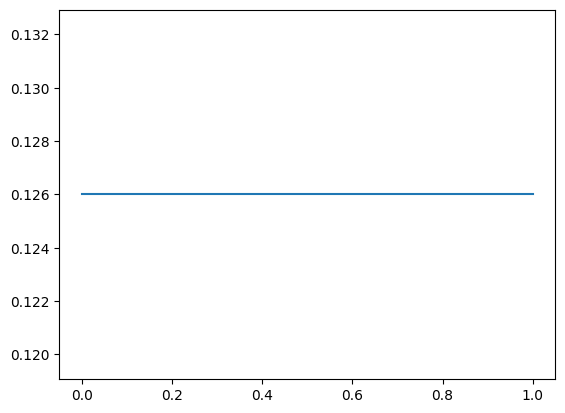

100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


In [27]:
# Time stepping
t = 0

for n in tqdm(range(100)):

  # Solve the problem
  uh_1 = local_branch_solution(bc_1, V_1, Ah_old_1, qh_old_1, A0_1, beta_1)
  uh_2 = local_branch_solution(bc_2, V_2, Ah_old_2, qh_old_2, A0_2, beta_2)
  uh_3 = local_branch_solution(bc_3, V_3, Ah_old_3, qh_old_3, A0_3, beta_3)

  Ah_1, qh_1 = uh_1.split(deepcopy = True)
  Ah_2, qh_2 = uh_2.split(deepcopy = True)
  Ah_3, qh_3 = uh_3.split(deepcopy = True)

  # Update previous solution
  Ah_old_1.assign(Ah_1)
  qh_old_1.assign(qh_1)
  Ah_old_2.assign(Ah_2)
  qh_old_2.assign(qh_2)
  Ah_old_3.assign(Ah_3)
  qh_old_3.assign(qh_3)

  # Update time step
  t += dt

  # Update bc
  A_inlet = A0_1 + 0.01 * t
  q_inlet = inlet_bc(Ah_1, qh_1, A0_1, beta_1, uh_1.dx(0), V_der_1, x_inlet)

  A_outlet_1, q_outlet_1 = outlet_bc(Ah_2, qh_2, A0_2, beta_2, uh_2.dx(0), V_der_2, x_outlet_1)
  A_outlet_2, q_outlet_2 = outlet_bc(Ah_3, qh_3, A0_3, beta_3, uh_3.dx(0), V_der_3, x_outlet_2)

  A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter = compute_branch_value(Ah_1, Ah_2, Ah_3, qh_1, qh_2, qh_3, uh_1, uh_2, uh_3, x_branch, 1e-5)

  bc_1, bc_2, bc_3 = update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3)

  if(n % 100 == 0):
    plot(Ah_1)
    plt.show()
    #print(f'At step {n} took {iter} iteration to impose the branching condition')


In [30]:
Ah_2.compute_vertex_values(mesh_2)

array([0.12600566, 0.12600542, 0.12600519, 0.12600497, 0.12600473,
       0.1260045 , 0.12600428, 0.12600405, 0.12600382, 0.12600359,
       0.12600336, 0.12600313, 0.1260029 , 0.12600267, 0.12600244,
       0.12600222, 0.12600199, 0.12600176, 0.12600153, 0.12600131,
       0.12600108, 0.12600086, 0.12600064, 0.12600044, 0.12600025,
       0.1260001 , 0.12599998, 0.12599991, 0.1259999 , 0.12599993,
       0.12599998, 0.12600003, 0.12600004])

In [31]:
qh_2.compute_vertex_values(mesh_2)

array([ 5.07898004e-03,  4.87228536e-03,  4.66652841e-03,  4.46093074e-03,
        4.25456396e-03,  4.04861801e-03,  3.84330190e-03,  3.63740498e-03,
        3.43146996e-03,  3.22625466e-03,  3.02076564e-03,  2.81499255e-03,
        2.60985903e-03,  2.40467503e-03,  2.19913999e-03,  1.99413720e-03,
        1.78923562e-03,  1.58407422e-03,  1.37957755e-03,  1.17573287e-03,
        9.72848432e-04,  7.73060384e-04,  5.78732131e-04,  3.94126275e-04,
        2.26859313e-04,  8.59230522e-05, -1.83965174e-05, -7.70269054e-05,
       -8.83217213e-05, -6.04695423e-05, -1.36144296e-05,  2.87512847e-05,
        3.61290941e-05])